In [2]:
# INSTALL NEEDED DEPENDENCIES
# ! pip install matplotlib
# ! pip install imbalanced-learn
# ! pip install jupyter
# ! pip install pandas
# ! pip install scipy==1.11.4

In [3]:
# IMPORTING NECESSARY LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from random import randrange
from scipy.stats import mode
from sklearn.cluster import k_means
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, f1_score, RocCurveDisplay, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from time import perf_counter

## Part A - Supervised Learning

#### 1) Data Loading and Feature Engineering
We begin by importing the Portuguese Marketing dataset, located at
https://www.kaggle.com/datasets/yufengsui/portuguese-bank-marketing-data-set?resource=download. <br>
Note: The .csv file has to be in the same folder as this notebook in order for the import to work correctly.

In [4]:
# DATA LOADING

# Ability to display all columns (eliminate column truncation)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None)

# Load dataset
data = pd.read_csv('bank-full.csv', sep=";") # since the file is semi colon-separated
#data = pd.read_csv('bank_cleaned.csv')

# Check the first few rows of the dataset
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


The representation of our columns are such:
- `age`: age
- `job`: type of job ("admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services")
- `marital`: marital status ("married", "divorced", "single")
- `education`: education ("unknown", "secondary", "primary", "tertiary")
- `default`: has credit in default? ("yes", "no")
- `balance`: average yearly balance
- `housing`: has housing loan? ("yes", "no")
- `loan`: has personal loan? ("yes", "no")
- `contact`: contact communication type ("unknown", "telephone", "cellular")
- `day`: last contact day of the month
- `month`: last contact month of the year ("jan", "feb", "mar", ..., "nov", "dec")
- `duration`: last contact duration (in seconds)
- `campaign`: number of contacts performed during this campaign and for this client
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (note: -1 means client was not previously contacted)
- `previous`: number of contacts performed before this campaign and for this client
- `poutcome`: outcome of the previous marketing campaign ("unknown", "other", "failure", "success")
- `y`: has the client subscribed a term deposit? ("yes", "no") (target variable)

In [5]:
# TAKING A CLOSER LOOK AT THE DATASET

# Check the types of values of our target feature and their count
data_target = data['y'].value_counts()
print(data_target)

# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

y
no     39922
yes     5289
Name: count, dtype: int64
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [6]:
# FEATURE ENGINEERING

# Mapping of month names to numbers
month_to_num = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
# Converting month names to integers
data['month'] = data['month'].str.lower().map(month_to_num)


# Mapping of columns with yes/no values
yes_no_mapping = {'no': 0, 'yes': 1}
# Applying the mapping to each column
data['y'] = data['y'].map(yes_no_mapping)
data['housing'] = data['housing'].map(yes_no_mapping)
data['loan'] = data['loan'].map(yes_no_mapping)
data['default'] = data['default'].map(yes_no_mapping)


In [7]:
# Categorical columns
categorical_cols = ['job', 'marital', 'education', 'contact', 'poutcome']

# Initializing the OneHotEncoder
encoder = OneHotEncoder()  

# Fitting and transforming the categorical data
encoded_features = encoder.fit_transform(data[categorical_cols]).toarray()

# Creating a DataFrame from the encoded features, ensuring to correctly name the columns
encoded_features_data = pd.DataFrame(encoded_features.astype(int), # one-hot encodes the features as 0 (false) or 1 (true)
                                   index=data.index, # preserving row order 
                                   columns=encoder.get_feature_names_out(categorical_cols)) # assigns meaningful column names

# Dropping the original categorical columns from the dataset
data = data.drop(categorical_cols, axis=1)

# Concatenating the original DataFrame (without the categorical columns) with the new encoded features DataFrame
data = pd.concat([data, encoded_features_data], axis=1)


In [8]:
# Assuming 'y' is the target and everything else are features
features = data.drop('y', axis=1)
target = data['y']

In [9]:
# Checking if there are no null values left
missing_values = data.isnull().sum()
print(missing_values)

# Check what the new dataset looks like
data.head()

age                    0
default                0
balance                0
housing                0
loan                   0
day                    0
month                  0
duration               0
campaign               0
pdays                  0
previous               0
y                      0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_divorced       0
marital_married        0
marital_single         0
education_primary      0
education_secondary    0
education_tertiary     0
education_unknown      0
contact_cellular       0
contact_telephone      0
contact_unknown        0
poutcome_failure       0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
dtype: int64


,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


### 2) Model Construction and Tuning

In [10]:
# SPLIT INTO TRAINING AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# CHECK COUNTS PRE SAMPLING
y_train.value_counts()

y
0    31917
1     4251
Name: count, dtype: int64

In [11]:
# RESAMPLE THE DATASET
oversampler = SMOTE(sampling_strategy=0.5)
undersampler = NearMiss(sampling_strategy=0.67)
X_train_bal, y_train_bal = oversampler.fit_resample(X_train, y_train)
X_train_bal, y_train_bal = undersampler.fit_resample(X_train_bal, y_train_bal)

# CHECK COUNTS POST SAMPLING
y_train_bal.value_counts()

y
0    23817
1    15958
Name: count, dtype: int64

In [12]:
# TRAIN RANDOM FOREST AS BASE MODEL ON SKEWED DATASET
base_model = RandomForestClassifier()

start = perf_counter()
base_model.fit(X_train, y_train)
end = perf_counter()
base_time = end - start

base_pred = base_model.predict(X_test)

In [13]:
# TRAIN RANDOM FOREST AS BASE MODEL ON BALANCED DATASET
base_model_bal = RandomForestClassifier()

start = perf_counter()
base_model_bal.fit(X_train_bal, y_train_bal)
end = perf_counter()
base_time_bal = end - start

base_pred_bal = base_model_bal.predict(X_test)

### 3) Model Evaluation

In [14]:
# EVAL METHOD TO BE USED THROUGHOUT
def eval_model(y_pred, runtime):
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
    print('F1 Score: ' + str(f1_score(y_test, y_pred)))
    print('Runtime: ' + str(runtime) + ' s')
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()

Accuracy: 0.9082162999004755
F1 Score: 0.5018007202881153
Runtime: 2.4920912930010672 s


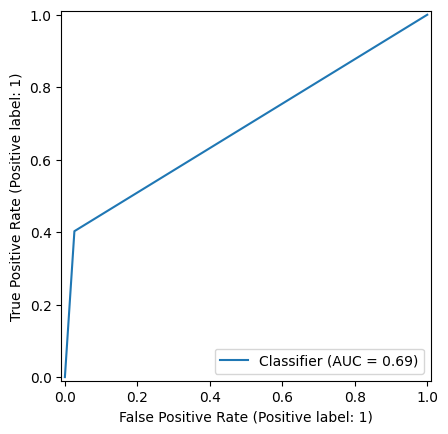

In [15]:
# EVALUATE BASE SKEWED MODEL
eval_model(base_pred, base_time)

Accuracy: 0.8905230565077961
F1 Score: 0.5524412296564195
Runtime: 2.5024019810007303 s


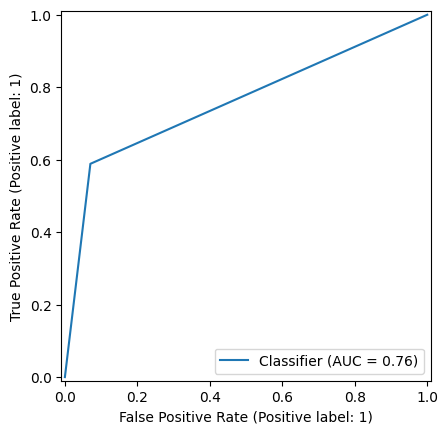

In [16]:
# EVALUATE BASE BALANCED MODEL
eval_model(base_pred_bal, base_time_bal)

## Part B - Semi-supervised Learning### 1) Self-training Algorithm

In [17]:
# CREATE SETS OF DATA WITH VARYING LEVELS OF LABELS
# -- skewed data --
# X_train and y_train are 100% labelled
# XL_50, XU_50, and y_50 are 50% labelled
XL_50, XU_50, y_50, _ = train_test_split(X_train, y_train, test_size=0.5)
# XL_75, XU_75, and y_75 are 25% labelled
XL_75, XU_75, y_75, _ = train_test_split(X_train, y_train, test_size=0.75)
# XL_90, XU_90, and y_90 are 10% labelled
XL_90, XU_90, y_90, _ = train_test_split(X_train, y_train, test_size=0.9)
# XL_95, XU_95, and y_95 are 5% labelled
XL_95, XU_95, y_95, _ = train_test_split(X_train, y_train, test_size=0.95)
# XL_99, XU_99, and y_99 are 1% labelled
XL_99, XU_99, y_99, _ = train_test_split(X_train, y_train, test_size=0.99)

# -- resampled data --
# X_train_bal and y_train_bal are 100% labelled
# XL_50_bal, XU_50_bal, and y_50_bal are 50% labelled
XL_50_bal, XU_50_bal, y_50_bal, _ = train_test_split(X_train_bal, y_train_bal, test_size=0.5)
# XL_75_bal, XU_75_bal, and y_75_bal are 25% labelled
XL_75_bal, XU_75_bal, y_75_bal, _ = train_test_split(X_train_bal, y_train_bal, test_size=0.75)
# XL_90_bal, XU_90_bal, and y_90_bal are 10% labelled
XL_90_bal, XU_90_bal, y_90_bal, _ = train_test_split(X_train_bal, y_train_bal, test_size=0.9)
# XL_95_bal, XU_95_bal, and y_95_bal are 5% labelled
XL_95_bal, XU_95_bal, y_95_bal, _ = train_test_split(X_train_bal, y_train_bal, test_size=0.95)
# XL_99_bal, XU_99_bal, and y_99_bal are 1% labelled
XL_99_bal, XU_99_bal, y_99_bal, _ = train_test_split(X_train_bal, y_train_bal, test_size=0.99)

### 1) Self-training Algorithm

In a semi-supervised learning approach, **self-training algorithms** play a significant role in leveraging both labeled and unlabeled data to improve the performance of machine learning models. This technique is particularly valuable when acquiring a large set of labeled data is expensive or impractical, but there's plenty of unlabeled data available.

How a self-training algorithm works:
1. `Training on Labeled Data`: The algorithm begins by training a model on the available labeled dataset. 
2. `Predicting Unlabeled Data`: The trained model is then used to make predictions on the unlabeled data. Since the model is not highly accurate at this stage, predictions might not be completely reliable. However, the algorithm typically selects only those predictions with high confidence to proceed to the next step.
3. `Self-Labeling`: The highly confident predictions on the unlabeled data are treated as "pseudo-labels." These pseudo-labeled examples are added to the training set, despite not being manually labeled. The assumption here is that the model is most likely correct in its high-confidence predictions, and thus these examples can be used to further train the model.
4. `Iterative Refinement`: The model is re-trained on this augmented dataset, which now contains both the original labeled data and the newly pseudo-labeled data. After re-training, the model may improve in accuracy because it has "learned" from a larger set of examples.
5. `Iteration`: Steps 2 through 4 are repeated several times. With each iteration, the model can potentially improve as it trains on an increasingly larger dataset augmented with pseudo-labeled examples. The process continues until a specified stopping criterion is met, which could be a certain number of iterations, a desired accuracy level, or when the model no longer improves significantly with further iterations.

In [18]:
# Function to implement the self-training algorithm
# The function takes as input the initially labeled data (XL, yL), the unlabeled data (XU), test data (X_test, y_test), max_iterations, and confidence_threshold 

def self_training(XL, yL, XU, X_test, y_test, max_iterations=10, confidence_threshold=0.75):
    start_time = time.time()

    # 1) Training the initial model on labeled data (XL, yL) using a logistic regression model
    clf = LogisticRegression(solver='liblinear', max_iter=1000)
    clf.fit(XL, yL)

    iterations = 0
    while iterations < max_iterations:
        iterations += 1

        # 2) Predict probabilities on the unlabeled data
        probas = clf.predict_proba(XU)
        max_probas = np.max(probas, axis=1)
        
        # 3) Self-Labeling
        high_confidence_mask = max_probas >= confidence_threshold
        if not np.any(high_confidence_mask):
            break  # No high-confidence predictions left
        
        # Instances from the unlabeled dataset predicted with high confidence are selected along with their predicted labels (y_high_confidence)
        X_high_confidence = XU[high_confidence_mask]
        y_high_confidence = np.argmax(probas[high_confidence_mask], axis=1)
        
        # Removing the high-confidence samples from unlabeled data
        XU = XU[~high_confidence_mask]

        # Adding high-confidence samples to labeled data
        XL = np.vstack((XL, X_high_confidence))
        yL = np.concatenate((yL, y_high_confidence))

        # 4) Re-training the classifier with the augmented labeled dataset
        clf.fit(XL, yL)
    
    # Evaluating the final model
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    runtime = time.time() - start_time
    
    return y_pred, runtime

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.9036824062811014
F1 Score: 0.44908285895003164
Runtime: 1.957266092300415 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


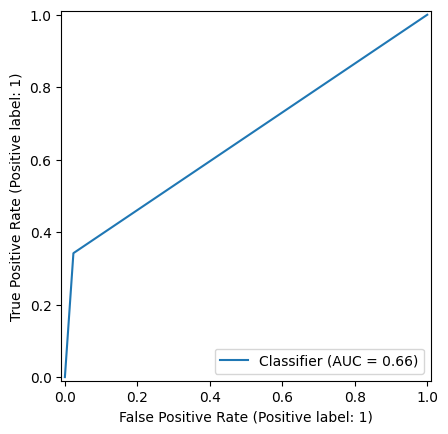

In [19]:
# SKEWED DATA WITH 50% UNLABELLED
y_pred, runtime = self_training(XL_50, y_50, XU_50, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.8853256662611965
F1 Score: 0.5012025012025012
Runtime: 2.923062562942505 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


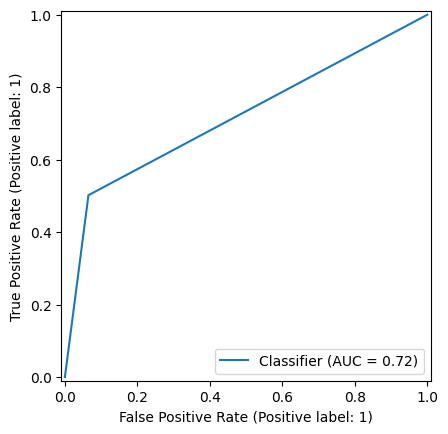

In [20]:
# BALANCED DATA WITH 50% UNLABELLED
y_pred, runtime = self_training(XL_50_bal, y_50_bal, XU_50_bal, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.9024659957978547
F1 Score: 0.4360613810741688
Runtime: 2.330446720123291 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


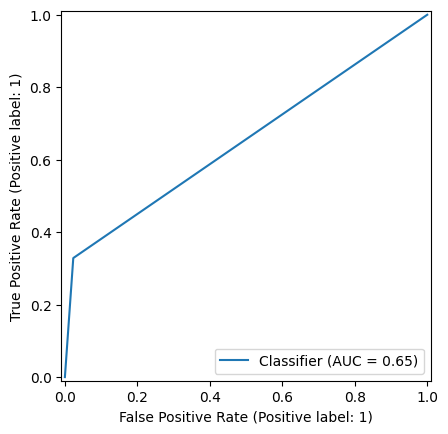

In [21]:
# SKEWED DATA WITH 75% UNLABELLED
y_pred, runtime = self_training(XL_75, y_75, XU_75, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.8890854804821409
F1 Score: 0.5046913580246913
Runtime: 2.7178657054901123 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


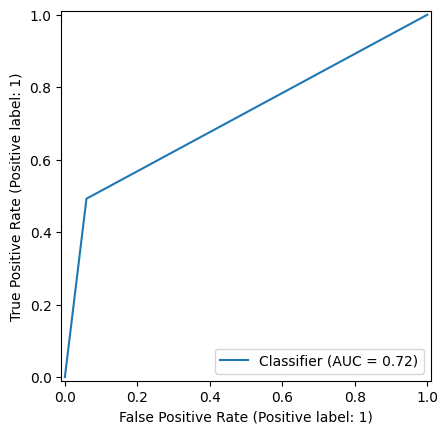

In [22]:
# BALANCED DATA WITH 75% UNLABELLED
y_pred, runtime = self_training(XL_75_bal, y_75_bal, XU_75_bal, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.9020236647130377
F1 Score: 0.4147952443857332
Runtime: 1.8839123249053955 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


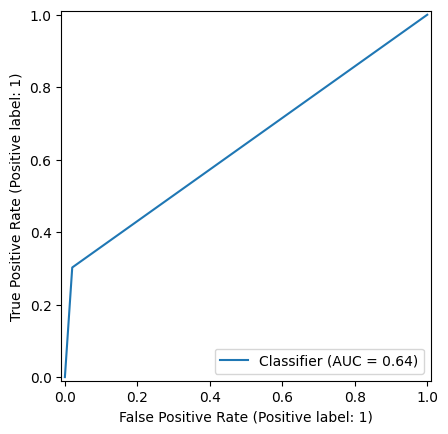

In [23]:
# SKEWED DATA WITH 90% UNLABELLED
y_pred, runtime = self_training(XL_90, y_90, XU_90, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.8805706070994139
F1 Score: 0.4924812030075188
Runtime: 2.6331024169921875 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


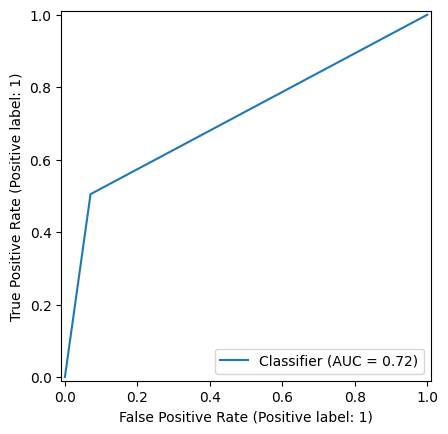

In [24]:
# BALANCED DATA WITH 90% UNLABELLED
y_pred, runtime = self_training(XL_90_bal, y_90_bal, XU_90_bal, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.8992590954329316
F1 Score: 0.3478883321403006
Runtime: 2.3377773761749268 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


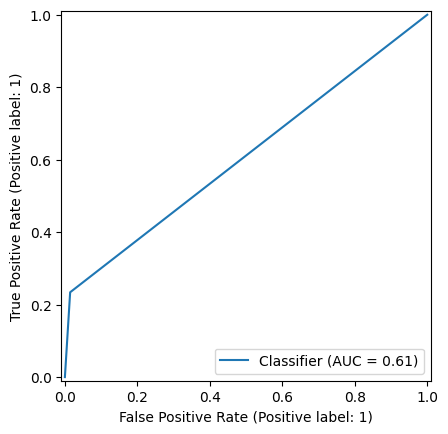

In [25]:
# SKEWED DATA WITH 95% UNLABELLED
y_pred, runtime = self_training(XL_95, y_95, XU_95, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.8793541966161672
F1 Score: 0.49977074736359467
Runtime: 2.43074369430542 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


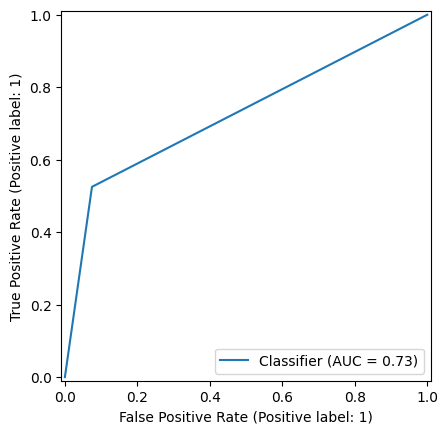

In [26]:
# BALANCED DATA WITH 95% UNLABELLED
y_pred, runtime = self_training(XL_95_bal, y_95_bal, XU_95_bal, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.8928452947030853
F1 Score: 0.2608695652173913
Runtime: 2.7216074466705322 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


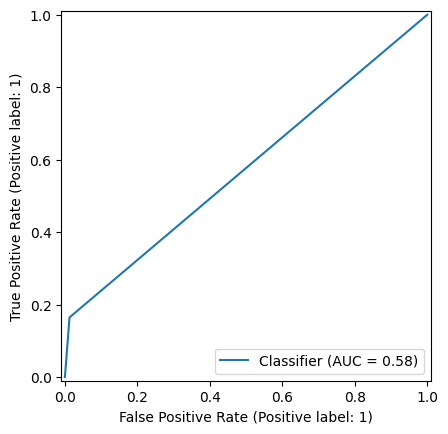

In [27]:
# SKEWED DATA WITH 99% UNLABELLED
y_pred, runtime = self_training(XL_99, y_99, XU_99, X_test, y_test)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-projec

Accuracy: 0.8556894835784584
F1 Score: 0.49980835569183596
Runtime: 1.8530099391937256 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


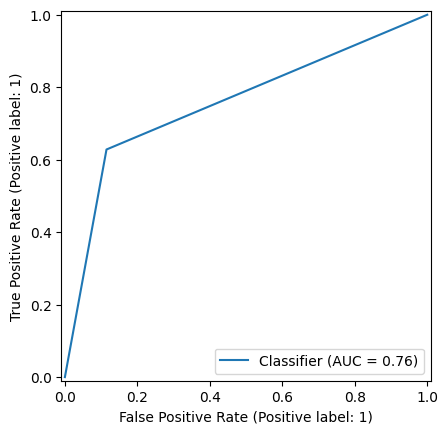

In [28]:
# BALANCED DATA WITH 99% UNLABELLED
y_pred, runtime = self_training(XL_99_bal, y_99_bal, XU_99_bal, X_test, y_test)
eval_model(y_pred, runtime)

### 2) Co-training Algorithm
Our co-training algorithm will use two Random Forest Classifiers to match the base model

In [29]:
# RANDOMLY SPLIT FEATURES
features_a = []
features_b = []
for feature in features.columns:
    rand = randrange(1)
    if len(features_a) == 19:
        features_b.append(feature)
    elif len(features_b) == 19:
        features_a.append(feature)
    elif rand == 0:
        features_a.append(feature)
    else:
        features_b.append(feature)

In [30]:
# DEFINE CO-TRAINING ALGORITHM
def co_train(XL, XU, yL):
    # Clone the data
    unlabelled_a = XU
    unlabelled_b = XU
    yL_a = yL
    yL_b = yL
    
    # Split the sets
    XL_a = XL.drop(features_a, axis=1)
    XL_b = XL.drop(features_b, axis=1)
    XU_a = XU.drop(features_a, axis=1)
    XU_b = XU.drop(features_b, axis=1)
    
    # Create the models
    co_train_model_a = RandomForestClassifier()
    co_train_model_b = RandomForestClassifier()
    
    # Define the starting confidence
    alpha = 0.9
    
    while (alpha >= 0.7) and (len(XU_a) > 0 or len(XU_b) > 0):
        # Train the two models on the data (only if there is new labelled data)
        if len(XL_a) > 0:
            co_train_model_a.fit(XL_a, yL_a)
        if len(XL_b) > 0:
            co_train_model_b.fit(XL_b, yL_b)
            
        # Reset the training sets
        XL_a = pd.DataFrame(None, columns=XL_a.columns)
        XL_b = pd.DataFrame(None, columns=XL_b.columns)
        yL_a = []
        yL_b = []
        new_unlabelled_a = pd.DataFrame(None, columns=unlabelled_a.columns)
        new_unlabelled_b = pd.DataFrame(None, columns=unlabelled_b.columns)
        new_XU_a = pd.DataFrame(None, columns=XU_a.columns)
        new_XU_b = pd.DataFrame(None, columns=XU_b.columns)
        
        if len(XU_a) > 0:
            # Make predictions on the unlabelled data
            pred_a = co_train_model_a.predict(XU_a)
            pred_proba_a = co_train_model_a.predict_proba(XU_a)
            
            for i in range(len(pred_a)):
                if max(pred_proba_a[i]) >= alpha:
                    # Add confident predictions to the next iteration of training
                    XL_b.loc[len(XL_b)] = unlabelled_a.drop(features_b, axis=1).iloc[i]
                    yL_b.append(pred_a[i])
                else:
                    # Add back to unlabelled set
                    new_unlabelled_a.loc[len(new_unlabelled_a)] = unlabelled_a.iloc[i]
                    new_XU_a.loc[len(new_XU_a)] = XU_a.iloc[i]
                    
        if len(XU_b) > 0:   
            # Make predictions on the unlabelled data
            pred_b = co_train_model_b.predict(XU_b)
            pred_proba_b = co_train_model_b.predict_proba(XU_b)

            for i in range(len(pred_b)):
                if max(pred_proba_b[i]) >= alpha:
                    # Add confident predictions to the next iteration of training
                    XL_a.loc[len(XL_a)] = unlabelled_b.drop(features_a, axis=1).iloc[i]
                    yL_a.append(pred_b[i])
                else:
                    # Add back to unlabelled set
                    new_unlabelled_b.loc[len(new_unlabelled_b)] = unlabelled_b.iloc[i]
                    new_XU_b.loc[len(new_XU_b)] = XU_b.iloc[i]
                
        unlabelled_a = new_unlabelled_a
        unlabelled_b = new_unlabelled_b
        XU_a = new_XU_a
        XU_b = new_XU_b
        
        # Lower the confidence if there's no new labels from either model
        if len(unlabelled_a) == 0 and len(unlabelled_b) == 0:
            alpha -= 0.1
    
    return co_train_model_a, co_train_model_b

In [31]:
def co_train_evaluate(model_a, model_b, runtime):
    pred = []
    
    test_a = X_test.drop(features_a, axis=1)
    test_b = X_test.drop(features_b, axis=1)
    
    pred_a = model_a.predict(test_a)
    pred_b = model_b.predict(test_b)
    pred_proba_a = model_a.predict_proba(test_a)
    pred_proba_b = model_b.predict_proba(test_b)
    
    for i in range(len(pred_a)):
        if max(pred_proba_a[i]) > max(pred_proba_b[i]):
            pred.append(pred_a[i])
        else:
            pred.append(pred_b[i])
            
    eval_model(pred, runtime)

Accuracy: 0.8852150834899922
F1 Score: 0.0
Runtime: 36.49659339600112 s


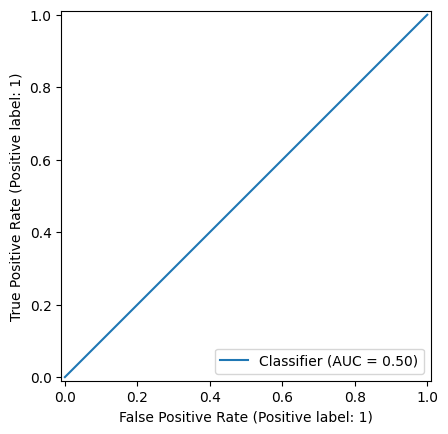

In [32]:
# SKEWED DATA WITH 50% UNLABELLED
start = perf_counter()
co_train_50_a, co_train_50_b = co_train(XL_50, XU_50, y_50)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_50_a, co_train_50_b, time)

Accuracy: 0.8852150834899922
F1 Score: 0.0
Runtime: 58.87338574900059 s


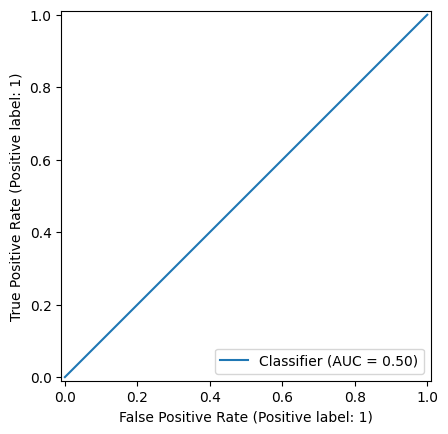

In [33]:
# BALANCED DATA WITH 50% UNLABELLED
start = perf_counter()
co_train_50_a_bal, co_train_50_b_bal = co_train(XL_50_bal, XU_50_bal, y_50_bal)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_50_a_bal, co_train_50_b_bal, time)

Accuracy: 0.8852150834899922
F1 Score: 0.0
Runtime: 53.95315204899998 s


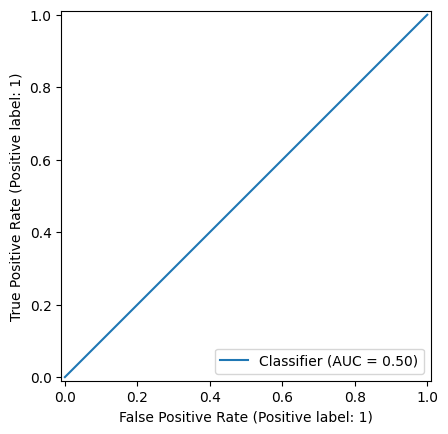

In [34]:
# SKEWED DATA WITH 75% UNLABELLED
start = perf_counter()
co_train_75_a, co_train_75_b = co_train(XL_75, XU_75, y_75)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_75_a, co_train_75_b, time)

Accuracy: 0.6344133583987615
F1 Score: 0.24761037778789258
Runtime: 97.28567665099945 s


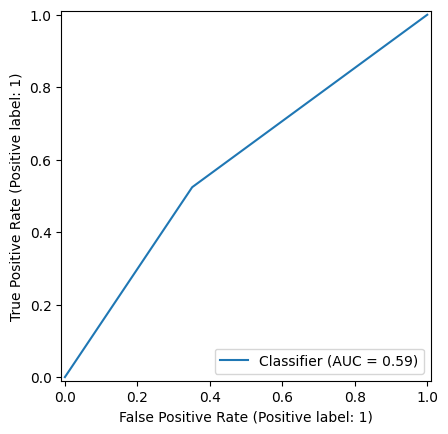

In [35]:
# BALANCED DATA WITH 75% UNLABELLED
start = perf_counter()
co_train_75_a_bal, co_train_75_b_bal = co_train(XL_75_bal, XU_75_bal, y_75_bal)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_75_a_bal, co_train_75_b_bal, time)

Accuracy: 0.8852150834899922
F1 Score: 0.0
Runtime: 72.3493834760011 s


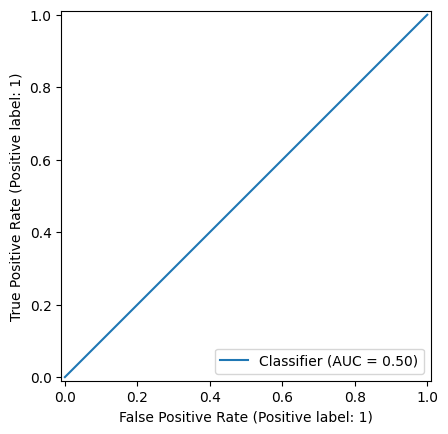

In [36]:
# SKEWED DATA WITH 90% UNLABELLED
start = perf_counter()
co_train_90_a, co_train_90_b = co_train(XL_90, XU_90, y_90)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_90_a, co_train_90_b, time)

Accuracy: 0.11478491651000775
F1 Score: 0.20593195119531793
Runtime: 72.3493834760011 s


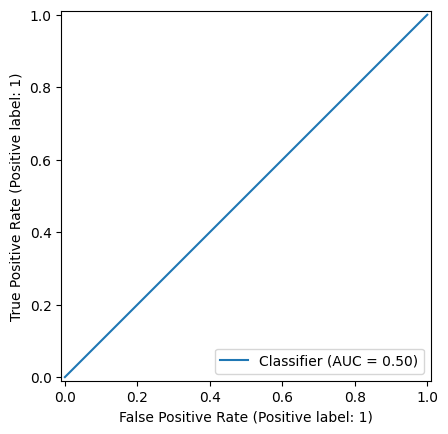

In [37]:
# BALANCED DATA WITH 90% UNLABELLED
start = perf_counter()
co_train_90_a_bal, co_train_90_b_bal = co_train(XL_90_bal, XU_90_bal, y_90_bal)
end = perf_counter()
count = end - start

co_train_evaluate(co_train_90_a_bal, co_train_90_b_bal, time)

Accuracy: 0.8852150834899922
F1 Score: 0.0
Runtime: 73.2803147249997 s


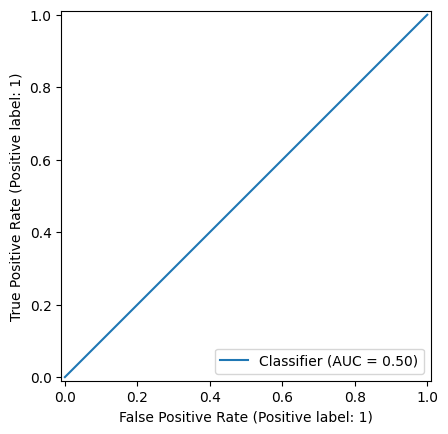

In [38]:
# SKEWED DATA WITH 95% UNLABELLED
start = perf_counter()
co_train_95_a, co_train_95_b = co_train(XL_95, XU_95, y_95)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_95_a, co_train_95_b, time)

Accuracy: 0.11478491651000775
F1 Score: 0.20593195119531793
Runtime: 134.6764239309996 s


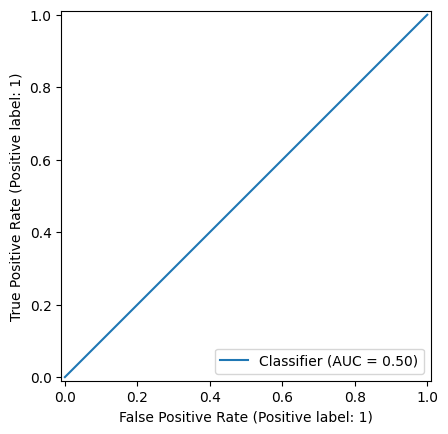

In [39]:
# BALANCED DATA WITH 95% UNLABELLED
start = perf_counter()
co_train_95_a_bal, co_train_95_b_bal = co_train(XL_95_bal, XU_95_bal, y_95_bal)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_95_a_bal, co_train_95_b_bal, time)

Accuracy: 0.8852150834899922
F1 Score: 0.0
Runtime: 85.62201633400036 s


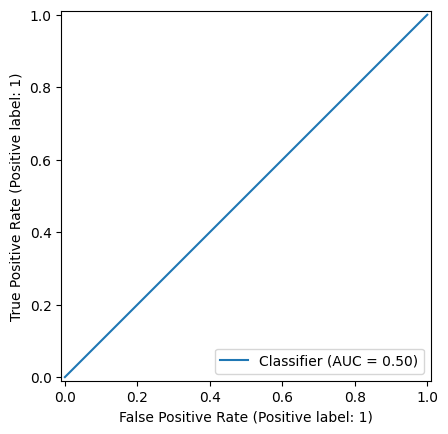

In [40]:
# SKEWED DATA WITH 99% UNLABELLED
start = perf_counter()
co_train_99_a, co_train_99_b = co_train(XL_99, XU_99, y_99)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_99_a, co_train_99_b, time)

Accuracy: 0.8852150834899922
F1 Score: 0.0
Runtime: 138.30512407100105 s


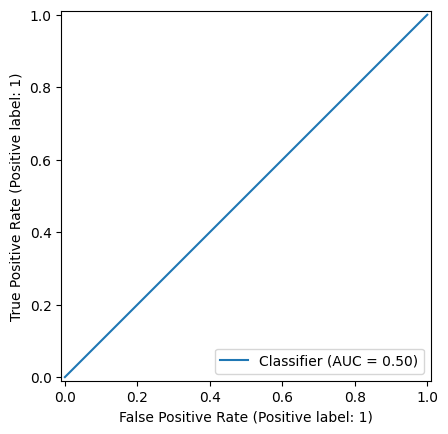

In [41]:
# BALANCED DATA WITH 99% UNLABELLED
start = perf_counter()
co_train_99_a_bal, co_train_99_b_bal = co_train(XL_99_bal, XU_99_bal, y_99_bal)
end = perf_counter()
time = end - start

co_train_evaluate(co_train_99_a_bal, co_train_99_b_bal, time)

### 3) Semi-supervised Ensemble

A **semi-supervised ensemble** combines multiple models in a semi-supervised learning context, aiming to leverage the strength of multiple learners to improve overall performance. This can be particularly effective in scenarios where different models capture different aspects of the data. There are various ways to construct a semi-supervised ensemble, but a common approach is to use a combination of labeled and unlabeled data to train individual models and then aggregate their predictions.

The approach to implementing a semi-supervised ensemble for a classification task:
1. `Divide the Labeled Data` into multiple subsets (with replacement, as in bagging).
2. `Train Individual Models` on each subset of labeled data.
3. `Predict on Unlabeled Data` with each model.
4. `Aggreagte Predictions` across models to label the unlabeled data.
5. `Combine the Newly Labeled Data` with the original labeled data.
6. `Train a Final Model`on this combined dataset.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import mode
import numpy as np
import time

def semi_supervised_ensemble(X_test, X_labeled, X_unlabeled, y_labeled):
    start_time = time.time()
    
    n_models = 5  # number of models in the ensemble
    ensemble = [LogisticRegression(max_iter=1000, random_state=i) for i in range(n_models)]

    # Hold the predictions for the unlabeled data from each model in the ensemble
    unlabeled_predictions = np.zeros((X_unlabeled.shape[0], n_models), dtype=int)

    # Creating a bootstrap sample (a sample with replacement) for each model from the labeled data
    for i, model in enumerate(ensemble):
        # Bootstrap sample from the labeled data
        indices = np.random.choice(range(X_labeled.shape[0]), size=X_labeled.shape[0], replace=True)
        X_bootstrap = X_labeled.iloc[indices]
        y_bootstrap = y_labeled.iloc[indices]
        
        model.fit(X_bootstrap, y_bootstrap) # model is trained on its bootstrap sample
        unlabeled_predictions[:, i] = model.predict(X_unlabeled) # predicts the labels of the unlabeled data

    # Predictions for the unlabeled data from all models in the ensemble are aggregated using a majority vote to decide the final label for each instance
    y_unlabeled_majority_vote, _ = mode(unlabeled_predictions, axis=1)
    y_unlabeled_majority_vote = y_unlabeled_majority_vote.flatten()

    # Labeled and unlabeled datasets are combined to form a new training dataset (including original labeled data and the unlabeled data with labels predicted by the ensemble)
    X_combined = np.vstack((X_labeled, X_unlabeled))
    y_combined = np.concatenate((y_labeled, y_unlabeled_majority_vote))

    # Training new model on the combined dataset
    final_model = LogisticRegression(max_iter=1000, random_state=42)
    final_model.fit(X_combined, y_combined)

    y_pred = final_model.predict(X_test)
    runtime = time.time() - start_time

    return y_pred, runtime

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.9026871613402632
F1 Score: 0.438058748403576
Runtime: 4.627436637878418 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


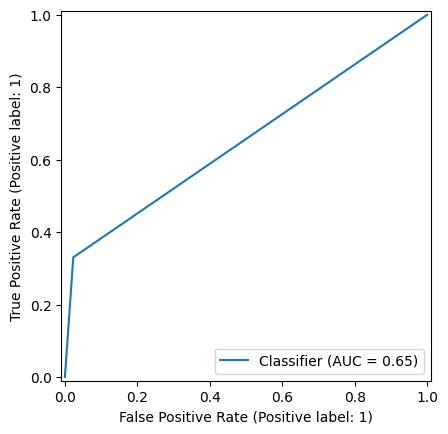

In [43]:
# SKEWED DATA WITH 50% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_50, XU_50, y_50)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.8751520513104059
F1 Score: 0.5093437635810517
Runtime: 5.4994261264801025 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


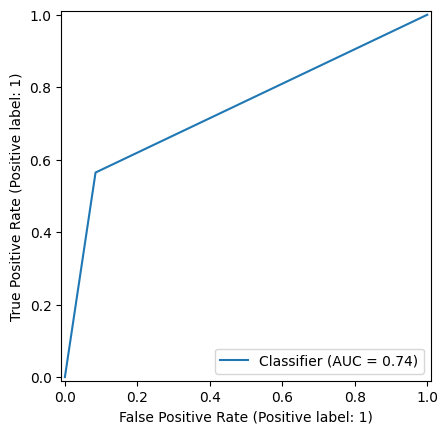

In [44]:
# BALANCED DATA WITH 50% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_50_bal, XU_50_bal, y_50_bal)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.9016919163994249
F1 Score: 0.4185742315238718
Runtime: 3.543236017227173 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


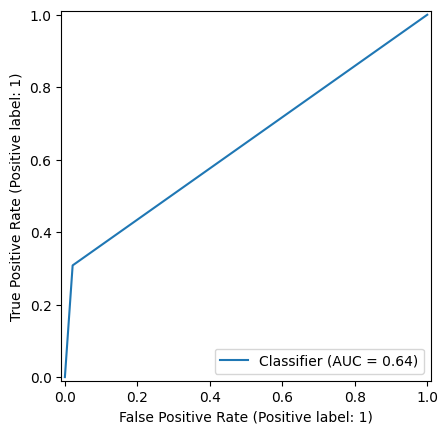

In [45]:
# SKEWED DATA WITH 75% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_75, XU_75, y_75)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.8775848722768993
F1 Score: 0.507343124165554
Runtime: 4.094578504562378 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


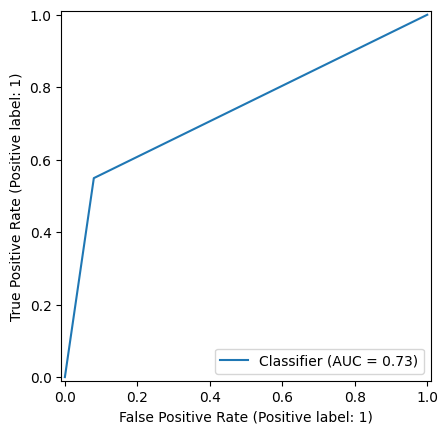

In [46]:
# BALANCED DATA WITH 75% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_75_bal, XU_75_bal, y_75_bal)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.9024659957978547
F1 Score: 0.42428198433420367
Runtime: 2.7463455200195312 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


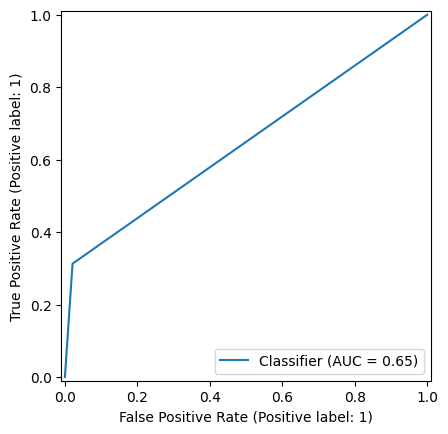

In [47]:
# SKEWED DATA WITH 90% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_90, XU_90, y_90)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.8666371779276789
F1 Score: 0.49875311720698257
Runtime: 3.0926826000213623 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


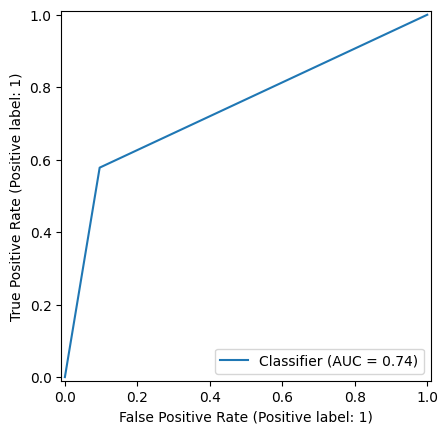

In [48]:
# BALANCED DATA WITH 90% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_90_bal, XU_90_bal, y_90_bal)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.8972686055512551
F1 Score: 0.38598810310641113
Runtime: 2.4575867652893066 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


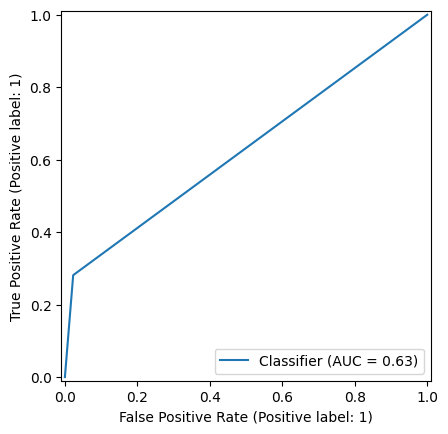

In [49]:
# SKEWED DATA WITH 95% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_95, XU_95, y_95)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.8687382505805595
F1 Score: 0.5129257283545343
Runtime: 2.9233527183532715 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


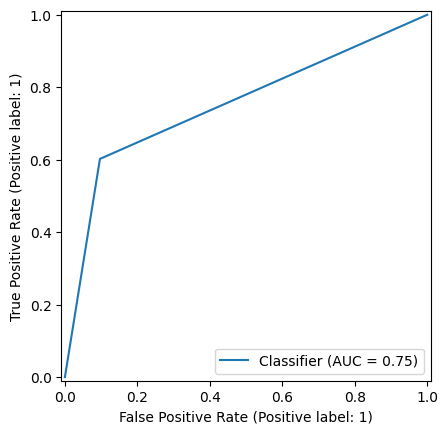

In [50]:
# BALANCED DATA WITH 95% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_95_bal, XU_95_bal, y_95_bal)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.8946146190423532
F1 Score: 0.34048442906574394
Runtime: 2.304276466369629 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


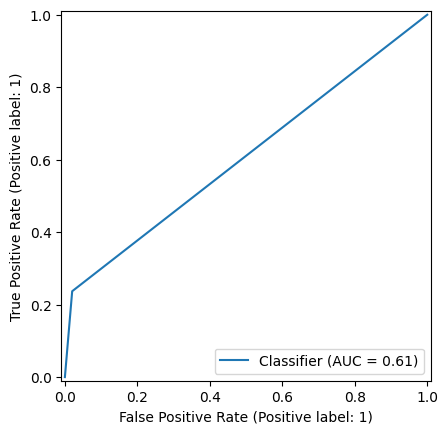

In [51]:
# SKEWED DATA WITH 95% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_99, XU_99, y_99)
eval_model(y_pred, runtime)

/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.846953444653323
F1 Score: 0.4855018587360595
Runtime: 2.6532957553863525 s


/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lain/anaconda3/envs/ml-project/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


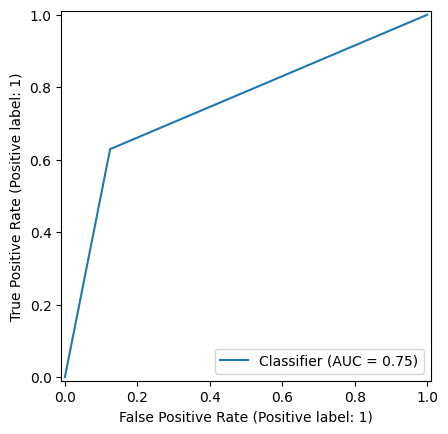

In [52]:
# BALANCED DATA WITH 99% UNLABELLED
y_pred, runtime = semi_supervised_ensemble(X_test, XL_99_bal, XU_99_bal, y_99_bal)
eval_model(y_pred, runtime)

### 4) Unsupervised Pretraining or Intrinsically Semi-Supervised Learning Method

In [53]:
def cluster_then_label(XL, XU, y):
    final_X = []
    final_y = []
    # Cluster the data
    XL_arr = XL.to_numpy()
    XU_arr = XU.to_numpy()
    y_arr = y.to_numpy()
    _, label, _ = k_means(np.concatenate([XL_arr, XU_arr]), 2)
    # Train models on each cluster
    model_a = RandomForestClassifier()
    model_b = RandomForestClassifier()
    X_a = []
    X_b = []
    y_a = []
    y_b = []
    for i in range(len(label)):
        if i >= len(y):
            break
        if label[i] == 0:
            X_a.append(XL_arr[i])
            y_a.append(y_arr[i])
        else:
            X_b.append(XL_arr[i])
            y_b.append(y_arr[i])
        final_X.append(XL_arr[i])
        final_y.append(y_arr[i])
    model_a.fit(X_a, y_a)
    model_b.fit(X_b, y_b)
    # Classify the unlabelled data
    for i in range(len(label)):
        if i < len(y):
            continue
        elif label[i] == 0:
            final_y.append(model_a.predict([XU_arr[i - len(y)]])[0])
        else:
            final_y.append(model_b.predict([XU_arr[i - len(y)]])[0])
        final_X.append(XU_arr[i - len(y)])
    # Return X and y for training
    return final_X, final_y

Accuracy: 0.9064469755612076
F1 Score: 0.4685929648241206
Runtime: 2.3382658979990083 s


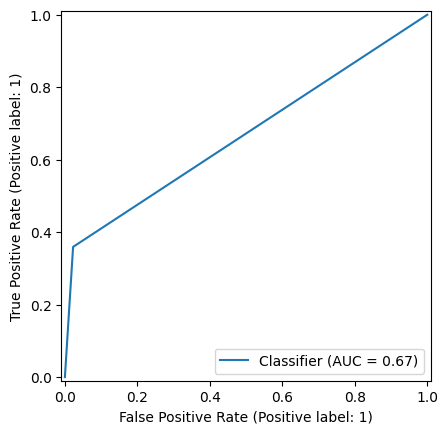

In [54]:
# SKEWED 50% UNLABELLED DATA
cl_X_50, cl_y_50 = cluster_then_label(XL_50, XU_50, y_50)

cl_50 = RandomForestClassifier()
start = perf_counter()
cl_50.fit(cl_X_50, cl_y_50)
end = perf_counter()
time = end - start

pred = cl_50.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.8914077186774301
F1 Score: 0.5572587917042381
Runtime: 2.4654782510006044 s


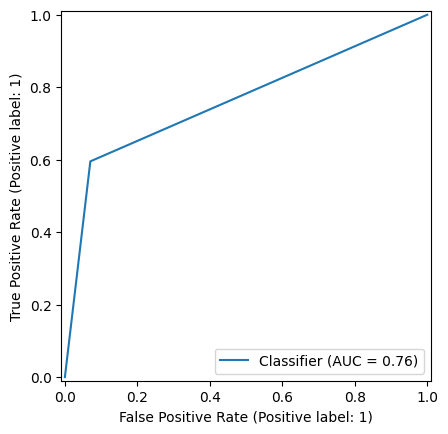

In [55]:
# BALANCED 50% UNLABELLED DATA
cl_X_50_bal, cl_y_50_bal = cluster_then_label(XL_50_bal, XU_50_bal, y_50_bal)

cl_50_bal = RandomForestClassifier()
start = perf_counter()
cl_50_bal.fit(cl_X_50_bal, cl_y_50_bal)
end = perf_counter()
time = end - start

pred = cl_50_bal.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.9052305650779608
F1 Score: 0.44169381107491856
Runtime: 2.247525074000805 s


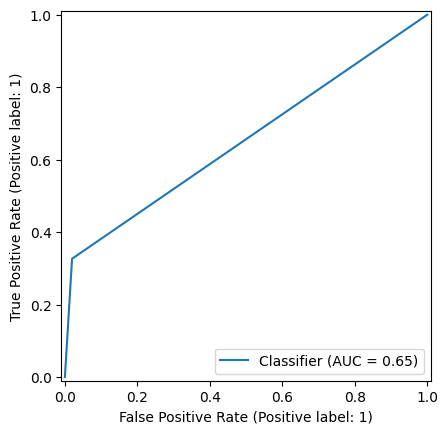

In [56]:
# SKEWED 75% UNLABELLED DATA
cl_X_75, cl_y_75 = cluster_then_label(XL_75, XU_75, y_75)

cl_75 = RandomForestClassifier()
start = perf_counter()
cl_75.fit(cl_X_75, cl_y_75)
end = perf_counter()
time = end - start

pred = cl_75.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.8826716797522945
F1 Score: 0.5490862728431789
Runtime: 2.397246880998864 s


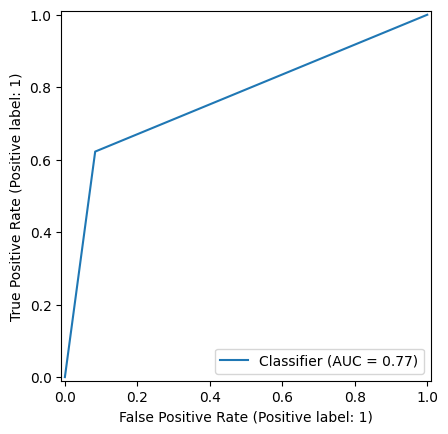

In [57]:
# BALANCED 75% UNLABELLED DATA
cl_X_75_bal, cl_y_75_bal = cluster_then_label(XL_75_bal, XU_75_bal, y_75_bal)

cl_75_bal = RandomForestClassifier()
start = perf_counter()
cl_75_bal.fit(cl_X_75_bal, cl_y_75_bal)
end = perf_counter()
time = end - start

pred = cl_75_bal.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.9031294924250802
F1 Score: 0.36796536796536794
Runtime: 2.0556764230004774 s


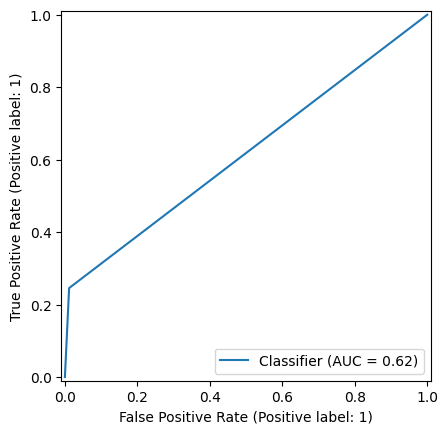

In [58]:
# SKEWED 90% UNLABELLED DATA
cl_X_90, cl_y_90 = cluster_then_label(XL_90, XU_90, y_90)

cl_90 = RandomForestClassifier()
start = perf_counter()
cl_90.fit(cl_X_90, cl_y_90)
end = perf_counter()
time = end - start

pred = cl_90.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.8703969921486232
F1 Score: 0.506318449873631
Runtime: 2.325394323001092 s


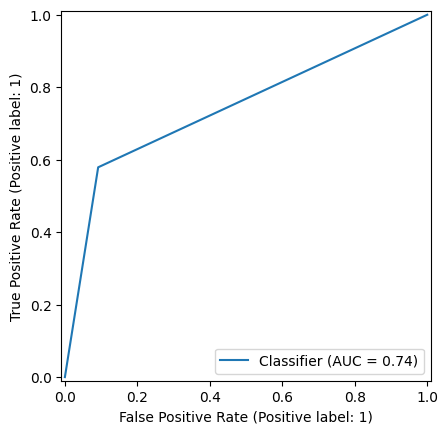

In [59]:
# BALANCED 90% UNLABELLED DATA
cl_X_90_bal, cl_y_90_bal = cluster_then_label(XL_90_bal, XU_90_bal, y_90_bal)

cl_90_bal = RandomForestClassifier()
start = perf_counter()
cl_90_bal.fit(cl_X_90_bal, cl_y_90_bal)
end = perf_counter()
time = end - start

pred = cl_90_bal.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.8946146190423532
F1 Score: 0.262954369682908
Runtime: 2.065555608000068 s


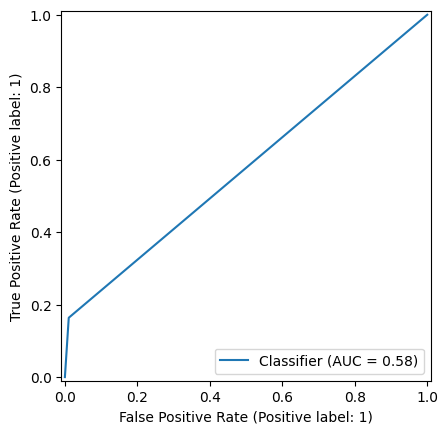

In [60]:
# SKEWED 95% UNLABELLED DATA
cl_X_95, cl_y_95 = cluster_then_label(XL_95, XU_95, y_95)

cl_95 = RandomForestClassifier()
start = perf_counter()
cl_95.fit(cl_X_95, cl_y_95)
end = perf_counter()
time = end - start

pred = cl_95.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.8586752184009732
F1 Score: 0.5
Runtime: 2.319269188999897 s


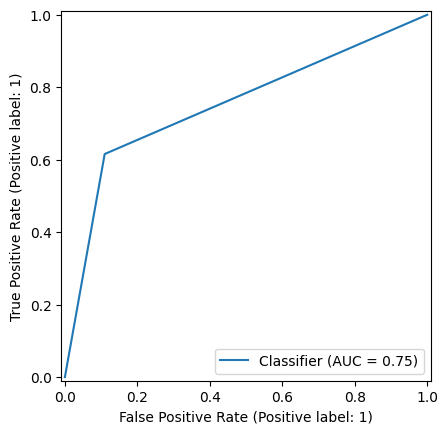

In [61]:
# BALANCED 95% UNLABELLED DATA
cl_X_95_bal, cl_y_95_bal = cluster_then_label(XL_95_bal, XU_95_bal, y_95_bal)

cl_95_bal = RandomForestClassifier()
start = perf_counter()
cl_95_bal.fit(cl_X_95_bal, cl_y_95_bal)
end = perf_counter()
time = end - start

pred = cl_95_bal.predict(X_test.to_numpy())
eval_model(pred, time)  

Accuracy: 0.8887537321685282
F1 Score: 0.12824956672443674
Runtime: 1.8125194869990082 s


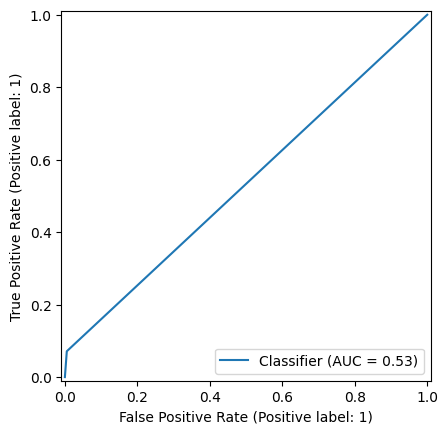

In [62]:
# SKEWED 99% UNLABELLED DATA
cl_X_99, cl_y_99 = cluster_then_label(XL_99, XU_99, y_99)

cl_99 = RandomForestClassifier()
start = perf_counter()
cl_99.fit(cl_X_99, cl_y_99)
end = perf_counter()
time = end - start

pred = cl_99.predict(X_test.to_numpy())
eval_model(pred, time)

Accuracy: 0.8203029967930996
F1 Score: 0.4624545153820708
Runtime: 2.250765061999118 s


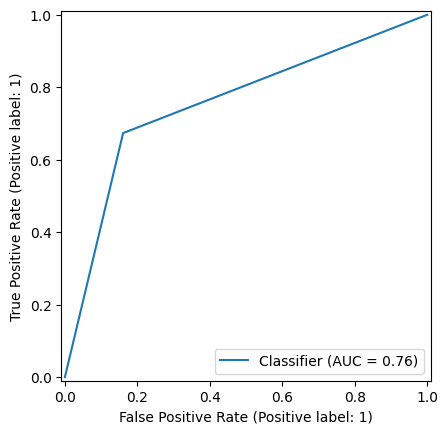

In [63]:
# BALANCED 99% UNLABELLED DATA
cl_X_99_bal, cl_y_99_bal = cluster_then_label(XL_99_bal, XU_99_bal, y_99_bal)

cl_99_bal = RandomForestClassifier()
start = perf_counter()
cl_99_bal.fit(cl_X_99_bal, cl_y_99_bal)
end = perf_counter()
time = end - start

pred = cl_99_bal.predict(X_test.to_numpy())
eval_model(pred, time)